In [1]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# open file
tracks = uproot.open("/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/track_reco_benchmark_reco_sample.root")
true_tracks = uproot.open("/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/track_reco_benchmark_truth_sample.root")
tracks["RecoBenchmarkTree"].show()
tracks["RecoBenchmarkTree"].keys()
tracks["RecoBenchmarkTree"][0].num_entries
tracks["RecoBenchmarkTree"]['caf_file_name']

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

<TBranchElement 'caf_file_name' at 0x7f46c1bd3250>

In [3]:
# Set up data frame
df = tracks["RecoBenchmarkTree"].arrays(library="pd")
df['caf_file_name'] = df['caf_file_name'][0][0]
df_true = true_tracks["RecoBenchmarkTree"].arrays(library="pd")
df_true['caf_file_name'] = df_true['caf_file_name'][0][0]

In [17]:
print("True:", len(df_true))
print("Reco:", len(df))

df_true['true_length']
df_true['true_angle_x']

True: 35852
Reco: 27626


entry  subentry
0      0           0.043608
       1           0.450660
       2           0.569494
       3           0.569494
       4                NaN
                     ...   
       35847            NaN
       35848            NaN
       35849            NaN
       35850            NaN
       35851            NaN
Name: true_angle_x, Length: 35852, dtype: float64

In [5]:
# DEFINE: Bins for length and angles
num_length_bins = 15
max_length = 150
length_bins = np.linspace(0.,max_length, num_length_bins)
beam_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)
rot_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)
incl_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)

# GET: Bin numbers for length and angles
reco_length_bin_nums = np.digitize(df['reco_length'], length_bins)
reco_beam_angle_bin_nums = np.digitize(df['reco_angle'], beam_angle_bins)
reco_rot_angle_bin_nums = np.digitize(df['reco_angle_rot'], rot_angle_bins)
reco_incl_angle_bin_nums = np.digitize(df['reco_angle_incl'], incl_angle_bins)

true_length_bin_nums = np.digitize(df_true['true_length'], length_bins)
true_beam_angle_bin_nums = np.digitize(df['true_angle'], beam_angle_bins)
true_rot_angle_bin_nums = np.digitize(df['true_angle_rot'], rot_angle_bins)
reco_incl_angle_bin_nums = np.digitize(df['reco_angle_incl'], incl_angle_bins)

# POPULATE: Add Bin numbers columns to df:
df['reco_length_bin'] = reco_length_bin_nums
df['reco_beam_angle_bin'] = reco_beam_angle_bin_nums
df['reco_angle_rot_bin'] = reco_rot_angle_bin_nums
df['reco_angle_incl_bin'] = reco_incl_angle_bin_nums

df_true['true_length_bin'] = true_length_bin_nums    
df['true_beam_angle_bin'] = true_beam_angle_bin_nums
df['true_angle_rot_bin'] = true_rot_angle_bin_nums
df['true_angle_incl_bin'] = reco_incl_angle_bin_nums

# CHECK: Progress
df

reco_energy   reco_p_x   reco_p_y   reco_p_z  reco_p_mag  \
entry subentry                                                             
0     0          100.000000 -11.521656  41.148655  90.527191  100.105608   
      1            0.061960  -0.050753   0.027386   0.116647    0.130124   
      2            0.033457   0.033963   0.037228   0.088989    0.102267   
      3            0.086786  -0.037848  -0.043507   0.150153    0.160845   
      4            0.078671   0.001887  -0.011324   0.150605    0.151042   
...                     ...        ...        ...        ...         ...   
      27621        0.075741  -0.237734  -0.070057  -0.294010    0.384535   
      27622        0.277068  -0.202244  -0.114882   0.736611    0.772461   
      27623      100.000000  64.193619  44.872173  63.665699  100.933908   
      27624        0.136830   0.046133  -0.017779  -0.212585    0.218258   
      27625        0.139857   0.017190   0.029520  -0.218968    0.221617   

                reco_length  reco_angle  reco_angle_rot  reco_angle_incl  \
entry subentry                                                             
0     0            5.712812    0.600269        1.805798         2.642246   
      1           15.010252    0.450084        1.901742         2.889038   
      2            8.354297    0.687051        1.072795         2.704965   
      3           13.695248    0.309766        1.799416        -2.872425   
      4            9.795029    0.032366        1.570796        -3.050933   
...                     ...         ...             ...              ...   
      27621        4.796102    2.259165        2.403273        -0.278300   
      27622       40.183393    0.217050        1.748277         3.074279   
      27623       25.629135    0.911160        0.898451         2.529055   
      27624       49.899737    2.900679        1.374041        -0.081636   
      27625       30.494829    3.038358        1.498031         0.131588   

                reco_angle_x  ...  subrun  \
entry subentry                ...           
0     0             1.805798  ...       0   
      1             1.901742  ...       0   
      2             1.072795  ...       0   
      3             1.799416  ...       0   
      4             1.570796  ...       0   
...                      ...  ...     ...   
      27621         2.403273  ...       0   
      27622         1.748277  ...       0   
      27623         0.898451  ...       0   
      27624         1.374041  ...       0   
      27625         1.498031  ...       0   

                                              caf_file_name   overlap  \
entry subentry                                                          
0     0         MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root  1.000000   
      1         MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root  1.000000   
      2         MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root  0.833333   
      3         MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root  1.000000   
      4         MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root  1.000000   
...                                                     ...       ...   
      27621     MiniRun5_1E19_RHC.caf.0000226.CAF.flat.root  0.221622   
      27622     MiniRun5_1E19_RHC.caf.0000226.CAF.flat.root  0.436170   
      27623     MiniRun5_1E19_RHC.caf.0000226.CAF.flat.root  0.777027   
      27624     MiniRun5_1E19_RHC.caf.0000226.CAF.flat.root  0.938650   
      27625     MiniRun5_1E19_RHC.caf.0000226.CAF.flat.root  0.988764   

                reco_length_bin  reco_beam_angle_bin  reco_angle_rot_bin  \
entry subentry                                                             
0     0                       1                   39                  46   
      1                       2                   39                  47   
      2                       1                   40                  42   
      3                       2                   38                  46   
      4                       1               

314.0


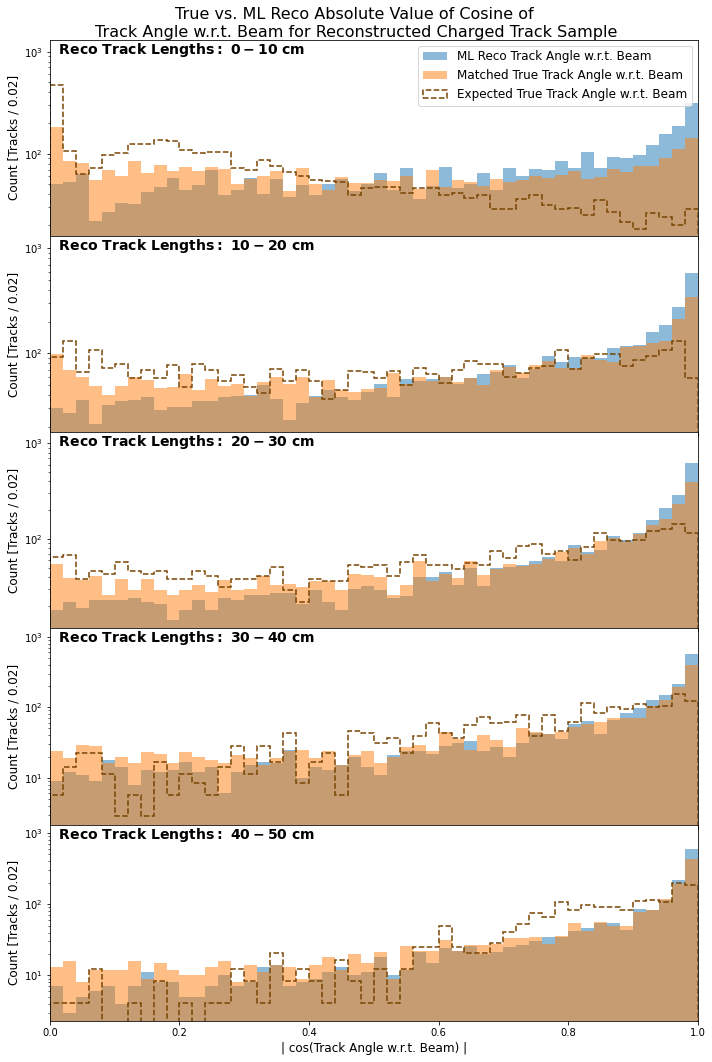

In [14]:
# CUT: Remove length bins with fewer than 5 tracks
ovlp_cut = 0.5
df_filtered = df[df['overlap']>=ovlp_cut]
global_scale_factor = len(df_filtered)/len(df_true)
sample = 'reco_charged_tracks_'
grouped_length = df_filtered.groupby('reco_length_bin')
true_grouped_length = df_true.groupby('true_length_bin')
stop_length_bin = 5
height = (stop_length_bin/num_length_bins)*45

fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    true_group = true_grouped_length.get_group(name)
    scale_factor = len(group)/len(true_group)
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Beam')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='Matched True Track Angle w.r.t. Beam')
    exp_counts, exp_bins, _ = axs[i].hist(abs(np.cos(true_group['true_angle'])), alpha=1, bins=50, range=(0, 1), histtype='step', label='Expected True Track Angle w.r.t. Beam', \
                                          weights=scale_factor*np.ones(len(true_group['true_angle'])), linestyle='dashed', color='#774300', linewidth=1.5)
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Track Angle w.r.t. Beam) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None,max_count+1000)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nTrack Angle w.r.t. Beam for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_angle_wrt_beam_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

336.0


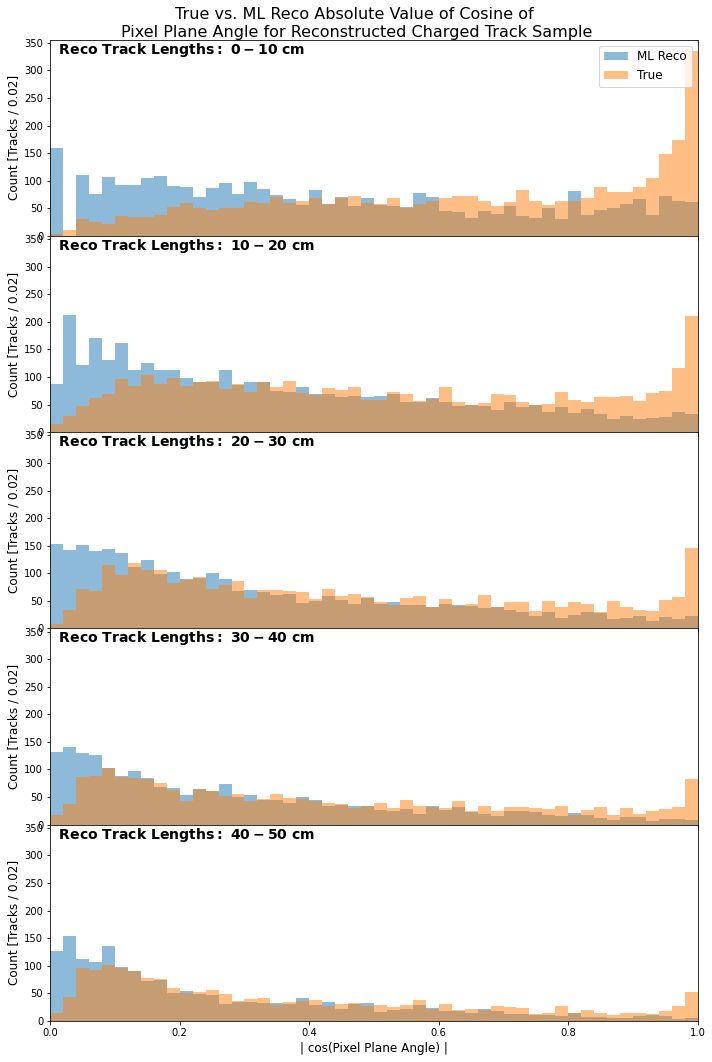

In [7]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Pixel Plane Angle) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+20)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_rot_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

765.0


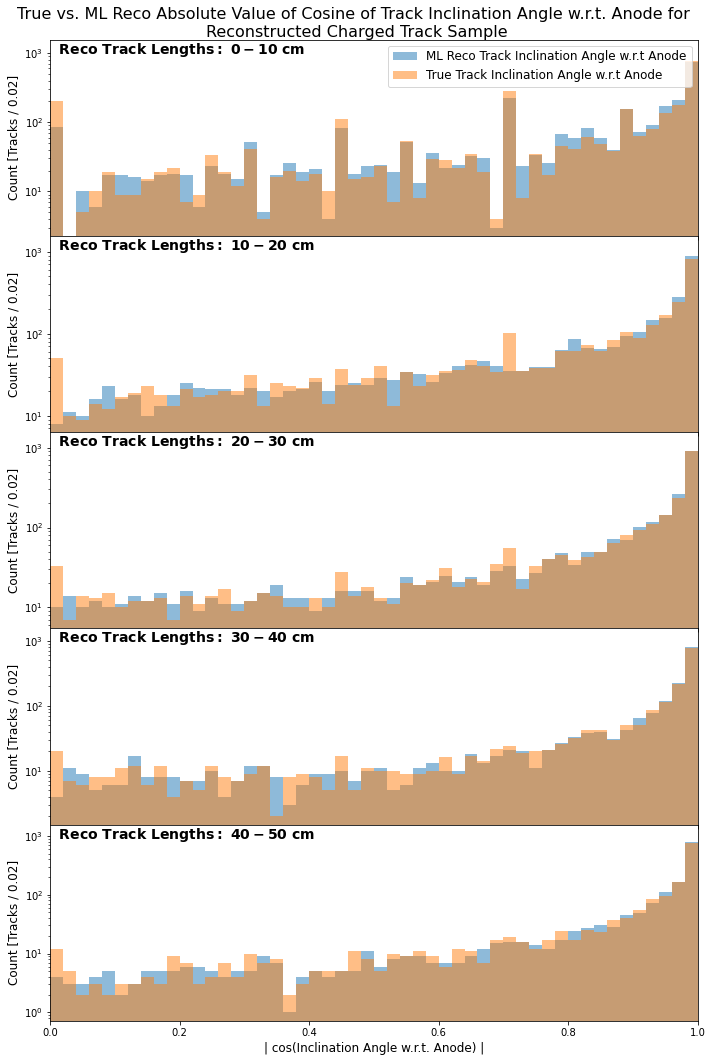

In [110]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_incl'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Inclination Angle w.r.t Anode')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_incl'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Inclination Angle w.r.t Anode')
    axs[i].set_xlabel('| cos(Inclination Angle w.r.t. Anode) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Inclination Angle w.r.t. Anode for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_incl_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

In [111]:
# Check track direction by looking at unit vectors
df_filtered['reco_x_dir'] = df_filtered['reco_track_end_x'] - df_filtered['reco_track_start_x']
df_filtered['reco_y_dir'] = df_filtered['reco_track_end_y'] - df_filtered['reco_track_start_y']
df_filtered['reco_z_dir'] = df_filtered['reco_track_end_z'] - df_filtered['reco_track_start_z']
df_filtered['true_x_dir'] = df_filtered['true_track_end_x'] - df_filtered['true_track_start_x']
df_filtered['true_y_dir'] = df_filtered['true_track_end_y'] - df_filtered['true_track_start_y']
df_filtered['true_z_dir'] = df_filtered['true_track_end_z'] - df_filtered['true_track_start_z']

df_filtered['reco_x_unit_dir'] = df_filtered['reco_x_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['reco_y_unit_dir'] = df_filtered['reco_y_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['reco_z_unit_dir'] = df_filtered['reco_z_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['true_x_unit_dir'] = df_filtered['true_x_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)
df_filtered['true_y_unit_dir'] = df_filtered['true_y_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)
df_filtered['true_z_unit_dir'] = df_filtered['true_z_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)


/tmp/ipykernel_24451/2218900340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reco_x_dir'] = df_filtered['reco_track_end_x'] - df_filtered['reco_track_start_x']
/tmp/ipykernel_24451/2218900340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reco_y_dir'] = df_filtered['reco_track_end_y'] - df_filtered['reco_track_start_y']
/tmp/ipykernel_24451/2218900340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

153.0


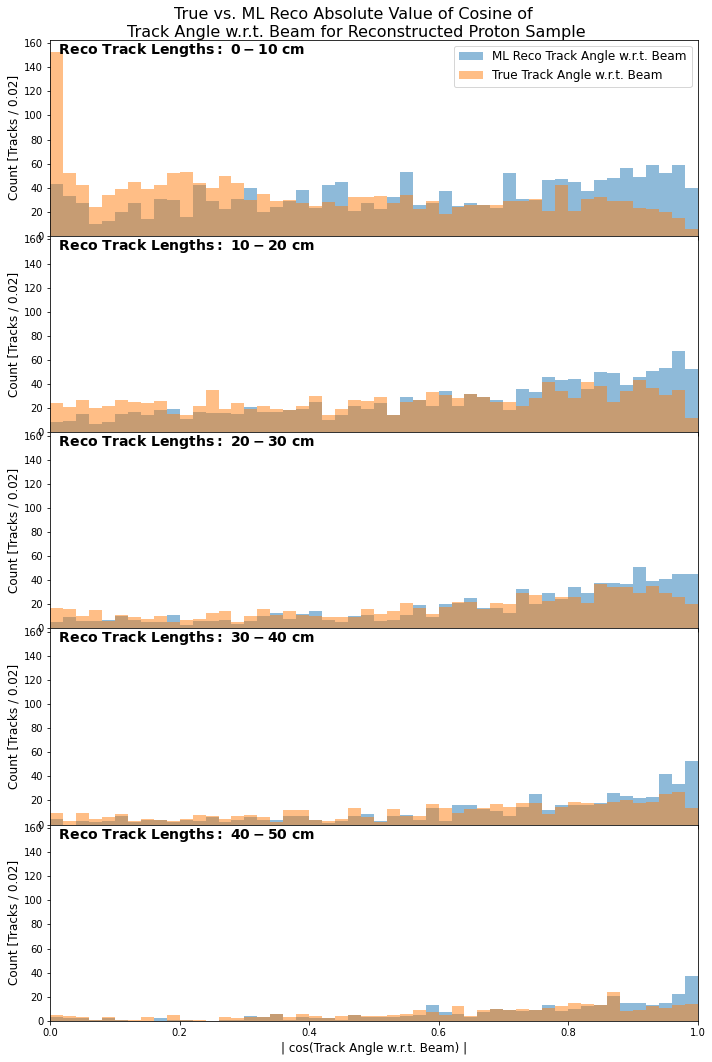

In [112]:
# PROTONS ONLY 
sample = 'reco_protons_'
df_protons = df_filtered[df_filtered['true_pdg'] == 2212]
grouped_length = df_protons.groupby('reco_length_bin')

fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Beam')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True Track Angle w.r.t. Beam')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Track Angle w.r.t. Beam) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+10)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nTrack Angle w.r.t. Beam for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_wrt_beam_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

218.0


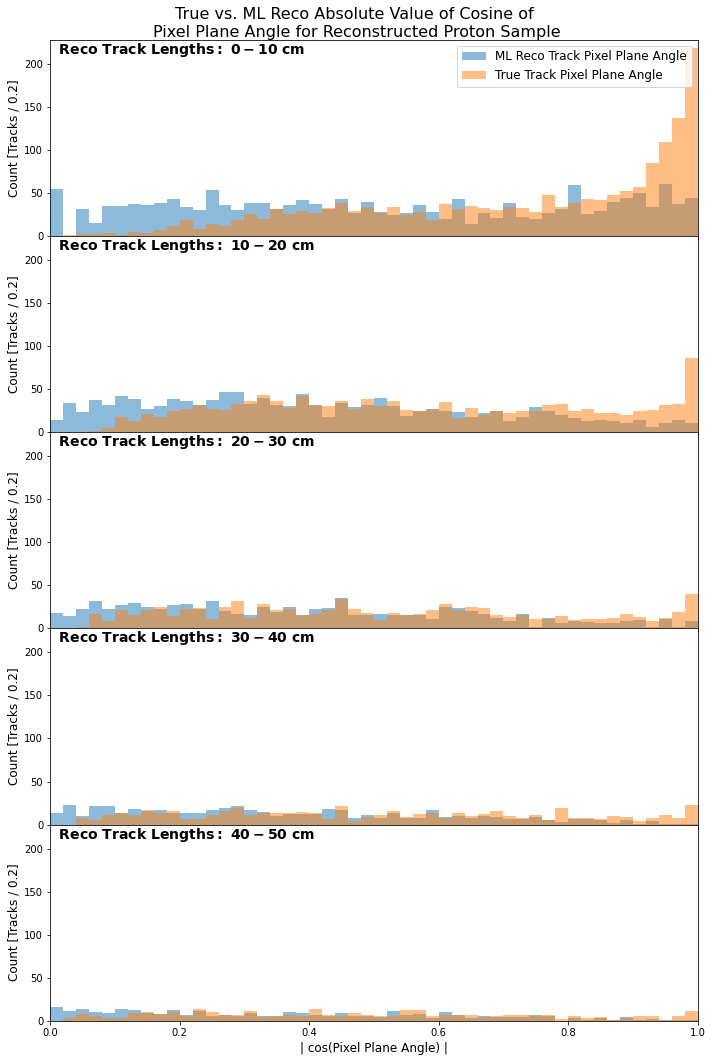

In [113]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Pixel Plane Angle')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True Track Pixel Plane Angle')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Pixel Plane Angle) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.2]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+10)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_rot_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

365.0


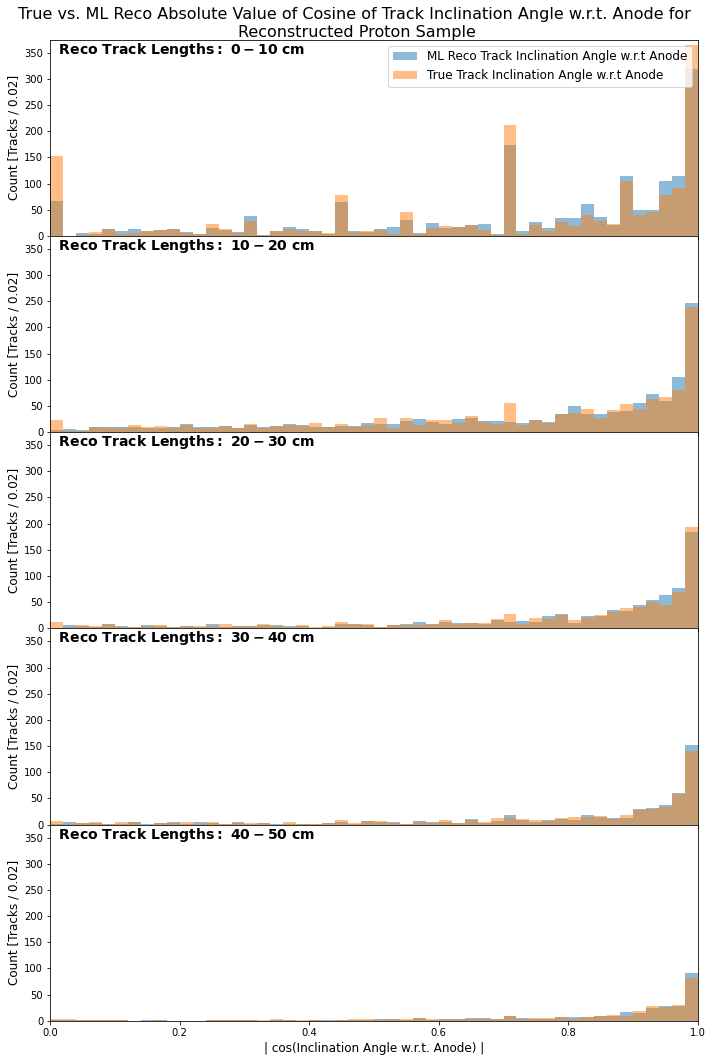

In [114]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_incl'])), alpha=0.5, bins=50, range=(0,1), histtype='stepfilled', label='ML Reco Track Inclination Angle w.r.t Anode')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_incl'])), alpha=0.5, bins=50, range=(0,1),histtype='stepfilled', label='True Track Inclination Angle w.r.t Anode')
    axs[i].set_xlabel('| cos(Inclination Angle w.r.t. Anode) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0, 1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_ylim(0, max_count+10.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Inclination Angle w.r.t. Anode for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_incl_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

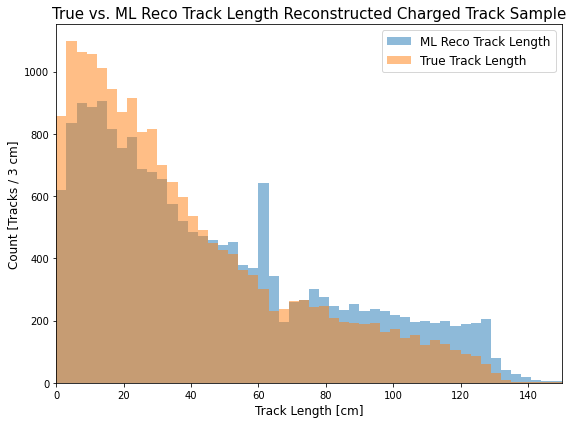

In [115]:
# Charged Track Lengths

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['reco_length'], alpha=0.5, bins=50, range=(0, 150), histtype='stepfilled', label='ML Reco Track Length')
true_counts, true_bins, _ = axs.hist(df_filtered['true_length'], alpha=0.5, bins=50, range=(0, 150),histtype='stepfilled', label='True Track Length')
axs.set_xlabel('Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs.set_xlim(0, 150)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
#fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()


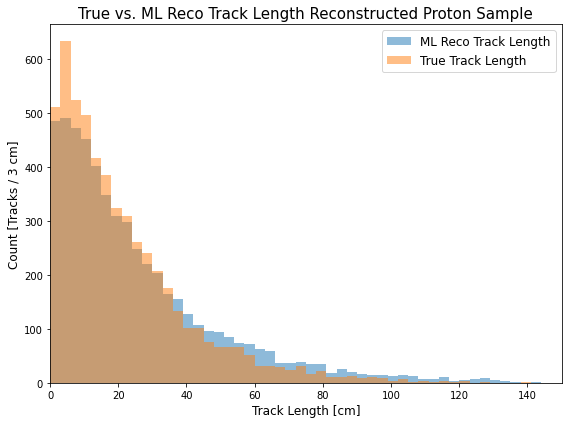

In [116]:
# Proton Track Lengths

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_protons['reco_length'], alpha=0.5, bins=50, range=(0, 150), histtype='stepfilled', label='ML Reco Track Length')
true_counts, true_bins, _ = axs.hist(df_protons['true_length'], alpha=0.5, bins=50, range=(0, 150),histtype='stepfilled', label='True Track Length')
axs.set_xlabel('Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs.set_xlim(0, 150)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Track Length Reconstructed Proton Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

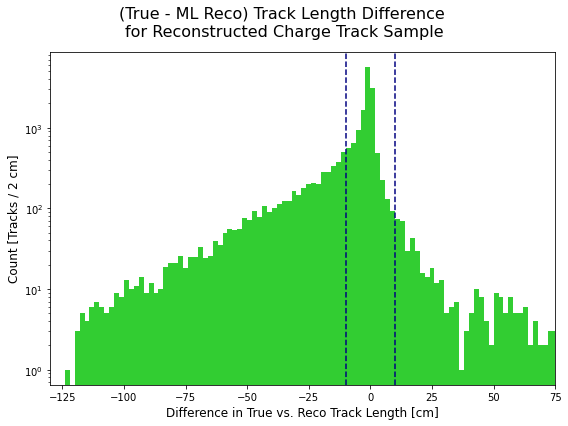

In [117]:
# Charged Track Lengths Difference

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist(df_filtered['true_length']-df_filtered['reco_length'], alpha=1.0, bins=150, range=(-150, 150),\
                                      histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. Reco Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 2 cm]', fontsize=12)
axs.set_xlim(-130, 75)
axs.set_yscale('log')
plt.axvline(x=10, color='navy', linestyle='--')  # Draw a red dashed line at x=10
plt.axvline(x=-10, color='navy', linestyle='--')  # Draw a red dashed line at x=-10


#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Track Length Difference \nfor Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

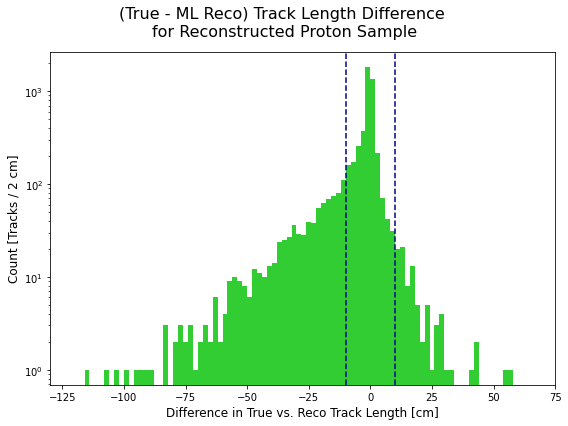

In [118]:
# Proton Track Lengths Difference

grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist(df_protons['true_length']-df_protons['reco_length'], alpha=1.0, bins=150, range=(-150, 150),\
                                      histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. Reco Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 2 cm]', fontsize=12)
axs.set_xlim(-130, 75)
axs.set_yscale('log')
plt.axvline(x=10, color='navy', linestyle='--')  # Draw a red dashed line at x=10
plt.axvline(x=-10, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Track Length Difference \nfor Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

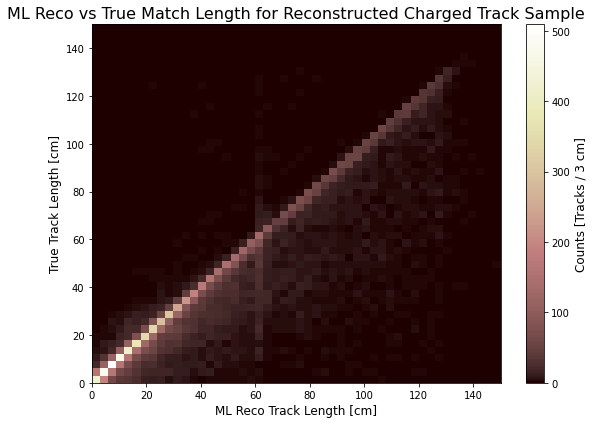

In [119]:
# Charged Track Lengths 2D Hist

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'

fig, ax = plt.subplots(figsize=[8,6])

counts, xedges, yedges, im = ax.hist2d(df_filtered['reco_length'], df_filtered['true_length'], bins=50, range=[[0, 150], [0, 150]], cmap='pink')

ax.set_xlabel('ML Reco Track Length [cm]', fontsize=12)
ax.set_ylabel('True Track Length [cm]', fontsize=12)
ax.set_title('ML Reco vs True Match Length for Reconstructed Charged Track Sample', fontsize=16)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts [Tracks / 3 cm]', fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_2d_hist_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

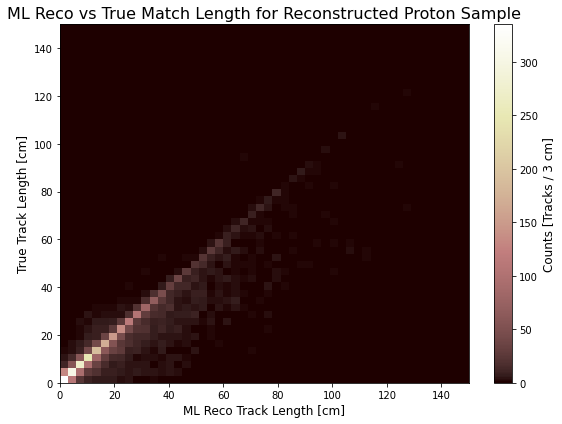

In [120]:
#Proton Track Lengths 2D Hist
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'

fig, ax = plt.subplots(figsize=[8,6])

counts, xedges, yedges, im = ax.hist2d(df_protons['reco_length'], df_protons['true_length'], bins=50, range=[[0, 150], [0, 150]], cmap='pink')

ax.set_xlabel('ML Reco Track Length [cm]', fontsize=12)
ax.set_ylabel('True Track Length [cm]', fontsize=12)
ax.set_title('ML Reco vs True Match Length for Reconstructed Proton Sample', fontsize=16)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts [Tracks / 3 cm]', fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_2d_hist_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

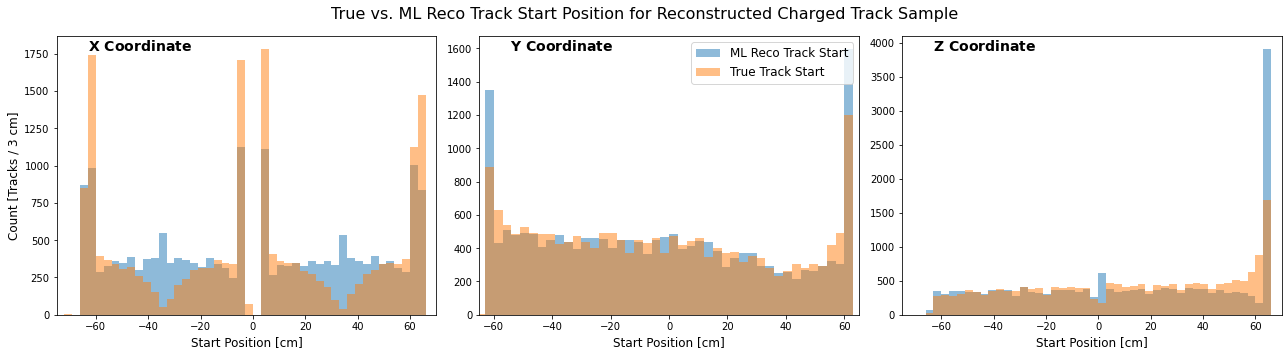

In [121]:
# Charged Track Start XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_filtered['reco_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsx, true_binsx, _x = axs[0].hist(df_filtered['true_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[0].set_xlabel('Start Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_filtered['reco_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsy, true_binsy, _y = axs[1].hist(df_filtered['true_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[1].set_xlabel('Start Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_filtered['reco_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsz, true_binsz, _z = axs[2].hist(df_filtered['true_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[2].set_xlabel('Start Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_start_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

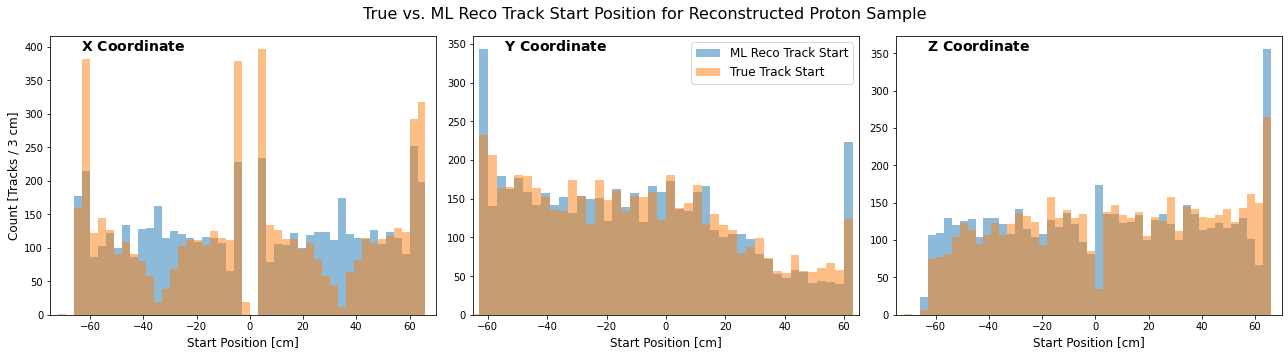

In [122]:
# Charged Track Start XYZ

grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_protons['reco_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsx, true_binsx, _x = axs[0].hist(df_protons['true_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[0].set_xlabel('Start Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_protons['reco_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsy, true_binsy, _y = axs[1].hist(df_protons['true_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[1].set_xlabel('Start Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_protons['reco_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsz, true_binsz, _z = axs[2].hist(df_protons['true_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[2].set_xlabel('Start Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_start_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

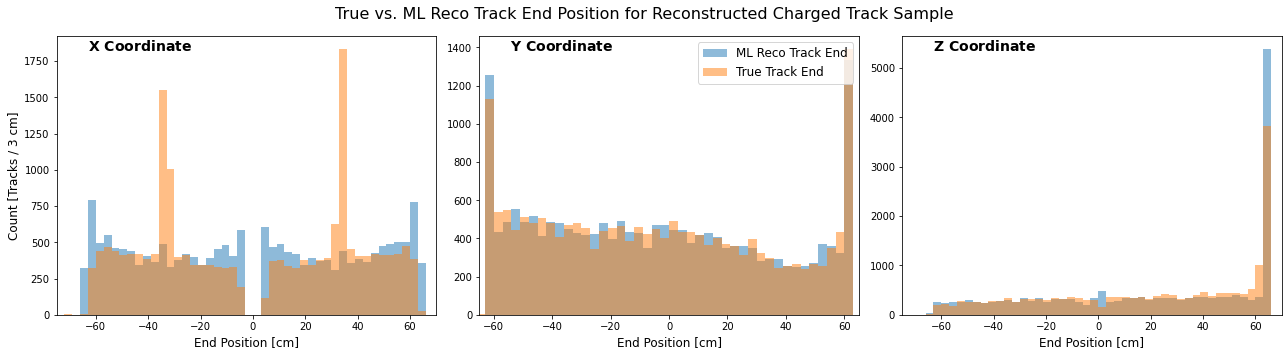

In [123]:
# Charged Track End XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_filtered['reco_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsx, true_binsx, _x = axs[0].hist(df_filtered['true_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[0].set_xlabel('End Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_filtered['reco_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsy, true_binsy, _y = axs[1].hist(df_filtered['true_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[1].set_xlabel('End Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_filtered['reco_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsz, true_binsz, _z = axs[2].hist(df_filtered['true_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[2].set_xlabel('End Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track End Position for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_end_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

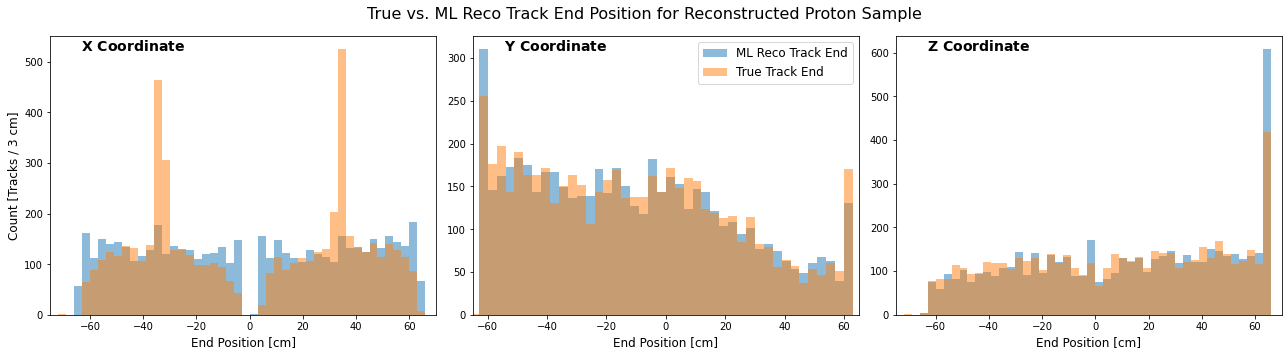

In [124]:
# Charged Track End XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_protons['reco_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsx, true_binsx, _x = axs[0].hist(df_protons['true_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[0].set_xlabel('End Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_protons['reco_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsy, true_binsy, _y = axs[1].hist(df_protons['true_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[1].set_xlabel('End Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_protons['reco_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsz, true_binsz, _z = axs[2].hist(df_protons['true_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[2].set_xlabel('End Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track End Position for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_end_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

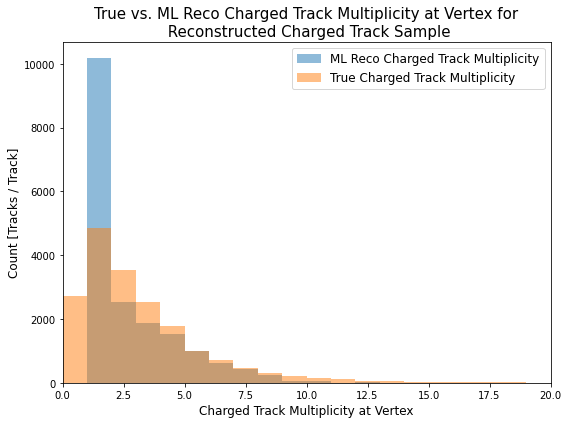

In [125]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['reco_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50), histtype='stepfilled', label='ML Reco Charged Track Multiplicity')
true_counts, true_bins, _ = axs.hist(df_filtered['true_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50),histtype='stepfilled', label='True Charged Track Multiplicity')
axs.set_xlabel('Charged Track Multiplicity at Vertex', fontsize=12)
axs.set_ylabel('Count [Tracks / Track]', fontsize=12)
axs.set_xlim(0, 20)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Charged Track Multiplicity at Vertex for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_charged_track_mult_at_vertex_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

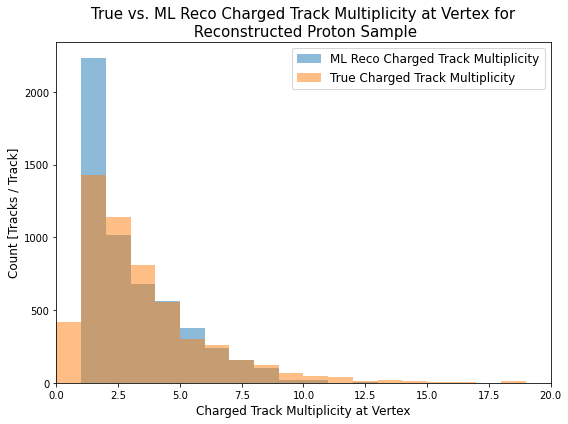

In [126]:
# Proton Track Mult at vertex

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_protons['reco_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50), histtype='stepfilled', label='ML Reco Charged Track Multiplicity')
true_counts, true_bins, _ = axs.hist(df_protons['true_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50),histtype='stepfilled', label='True Charged Track Multiplicity')
axs.set_xlabel('Charged Track Multiplicity at Vertex', fontsize=12)
axs.set_ylabel('Count [Tracks / Track]', fontsize=12)
axs.set_xlim(0, 20)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Charged Track Multiplicity at Vertex for\n Reconstructed Proton Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_charged_track_mult_at_vertex_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

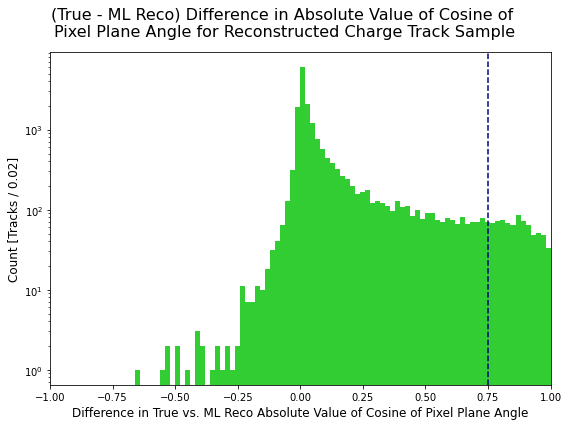

In [127]:
# Charged Track absolute cosine of angle rot difference

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_rot']))-abs(np.cos(df_filtered['reco_angle_rot']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Pixel Plane Angle', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_rot_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

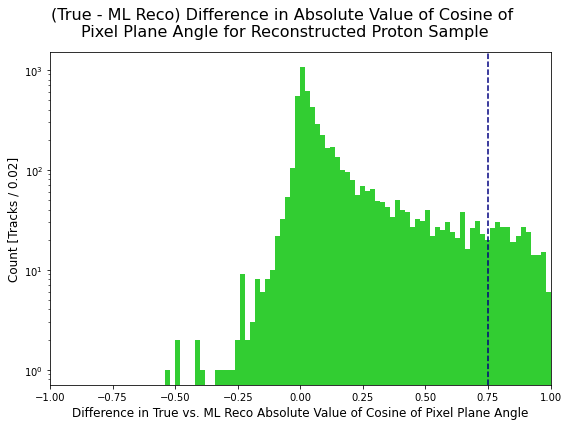

In [128]:
# Proton absolute cosine of angle rot difference

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_rot']))-abs(np.cos(df_protons['reco_angle_rot']))), alpha=1.0, \
                                     bins=100, range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Pixel Plane Angle', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_rot_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

In [129]:
print("Length of Charged Track Sample: ", len(df_filtered))
print("Length of Proton Sample: ", len(df_protons))


Length of Charged Track Sample:  18587
Length of Proton Sample:  5413


320.0


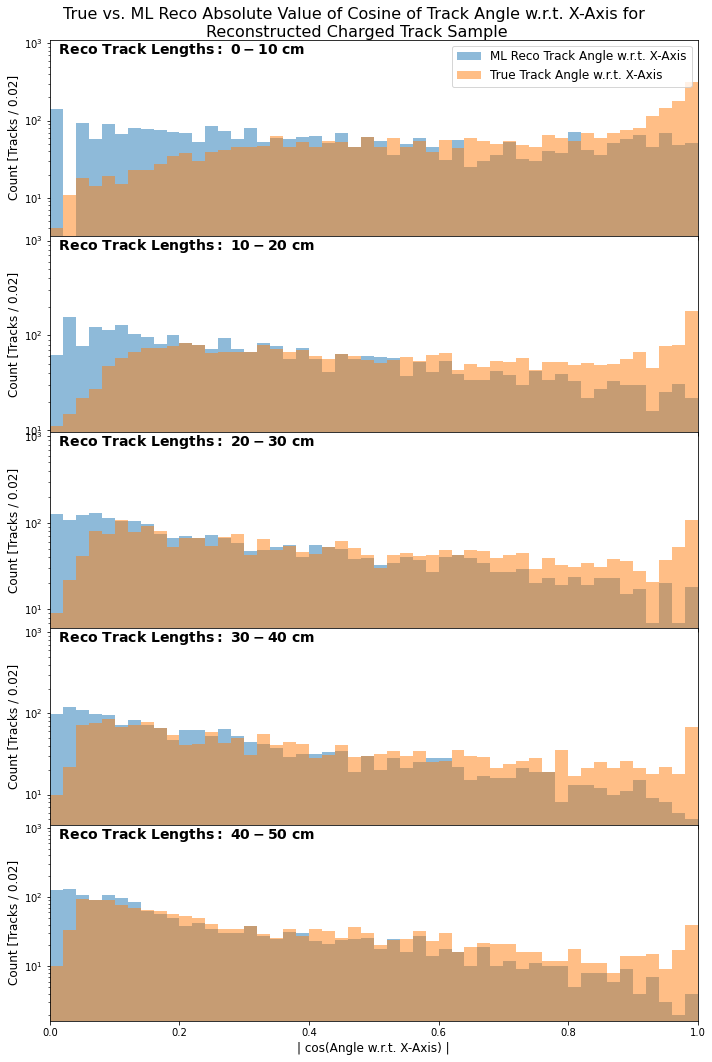

In [130]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_x'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. X-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_x'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. X-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. X-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_x_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

218.0


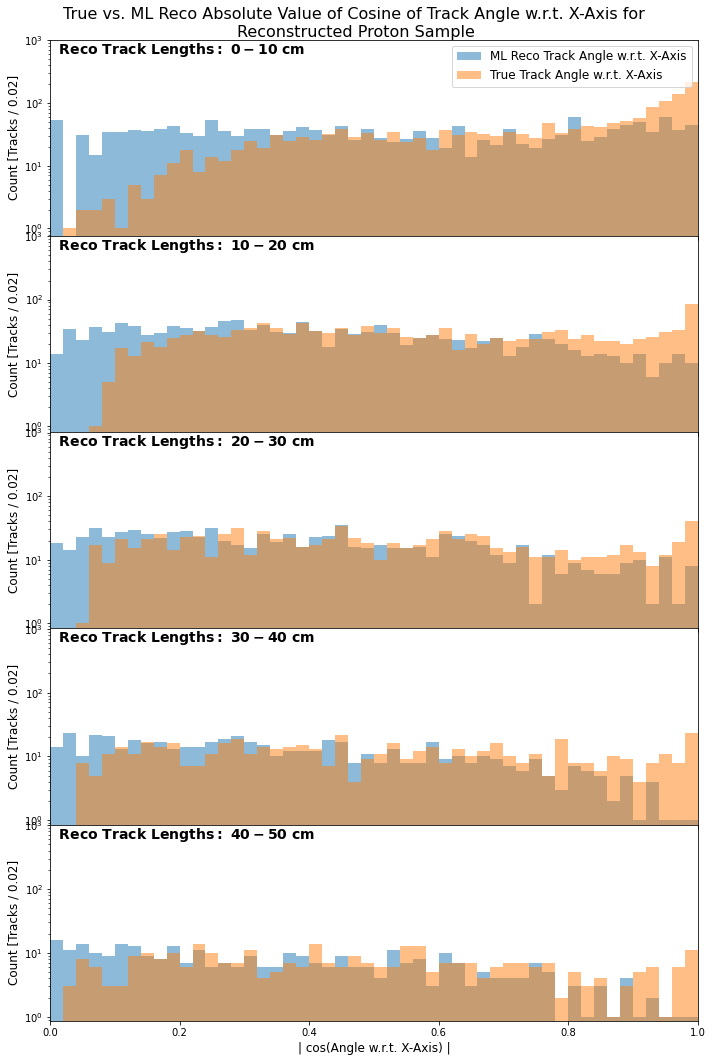

In [131]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_x'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. X-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_x'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. X-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. X-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_x_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

394.0


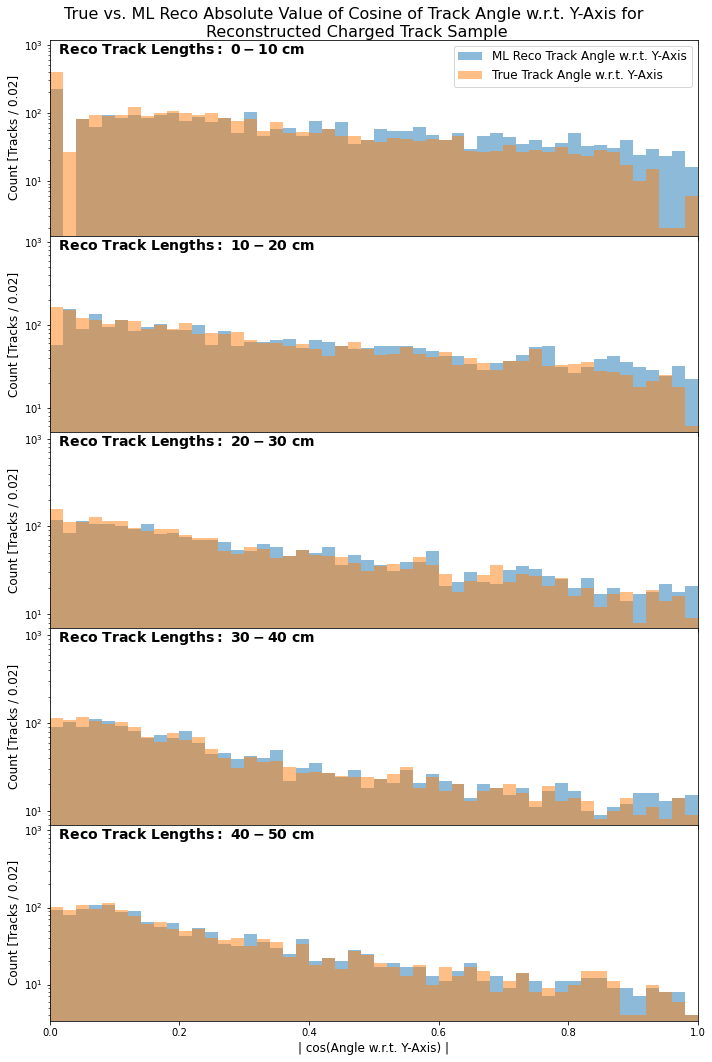

In [132]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_y'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Y-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_y'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Y-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Y-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_y_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

230.0


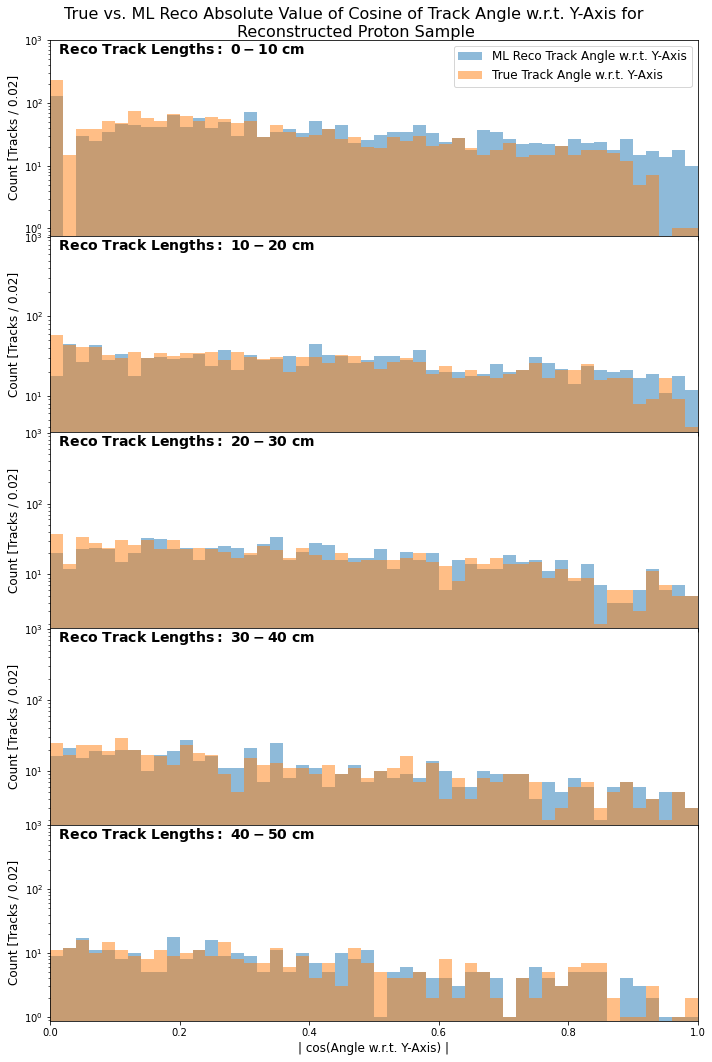

In [133]:




grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_y'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Y-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_y'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Y-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Y-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_y_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

275.0


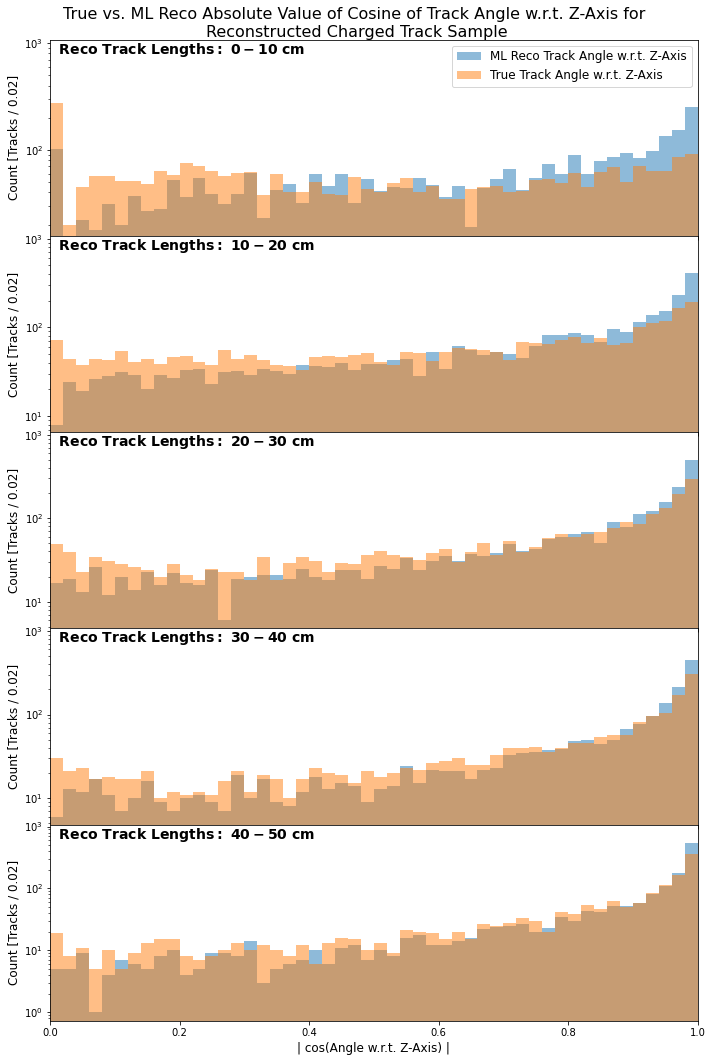

In [134]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_z'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Z-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_z'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Z-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Z-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_z_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

203.0


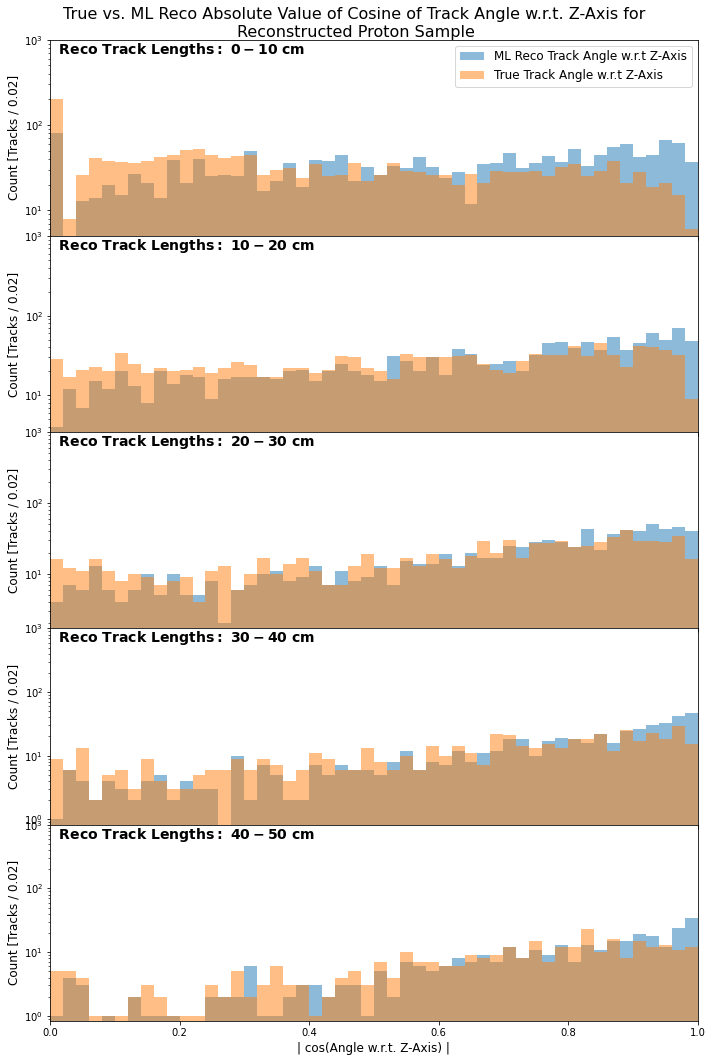

In [135]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_z'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t Z-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_z'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t Z-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Z-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_z_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

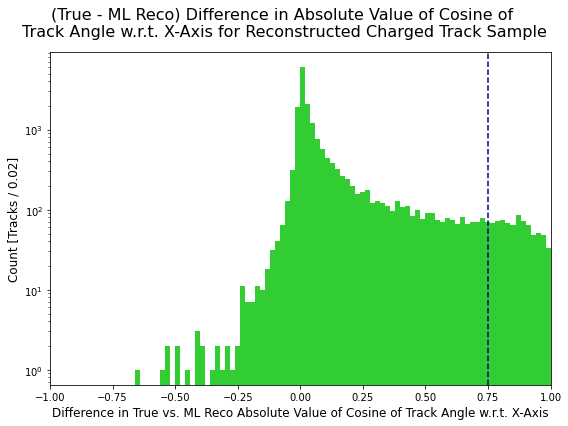

In [136]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_x']))-abs(np.cos(df_filtered['reco_angle_x']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. X-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_x_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

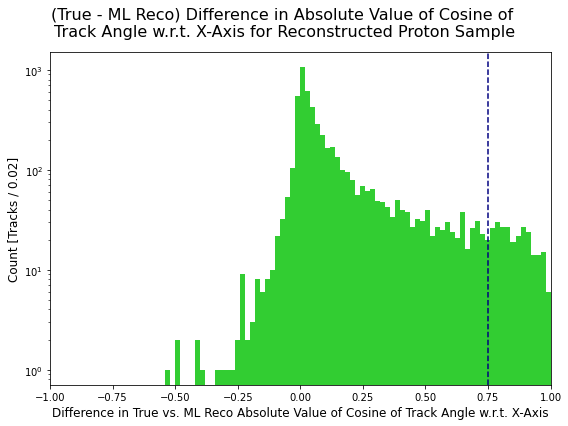

In [137]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_x']))-abs(np.cos(df_protons['reco_angle_x']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. X-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_x_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

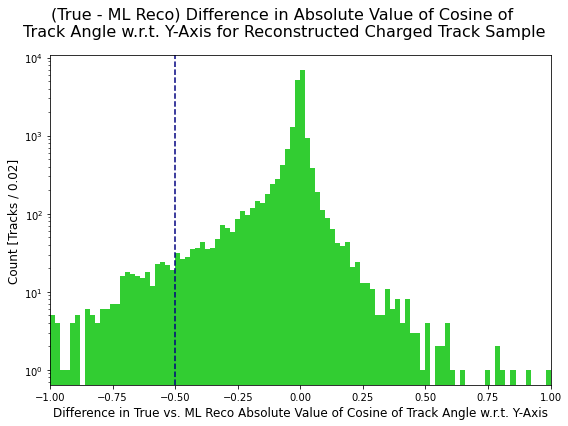

In [138]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_y']))-abs(np.cos(df_filtered['reco_angle_y']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Y-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_y_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

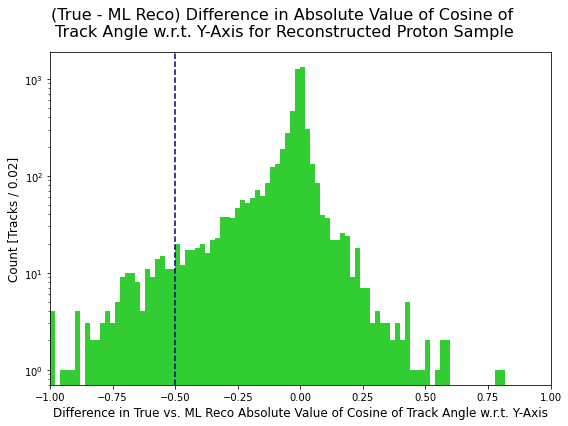

In [139]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_y']))-abs(np.cos(df_protons['reco_angle_y']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Y-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_y_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

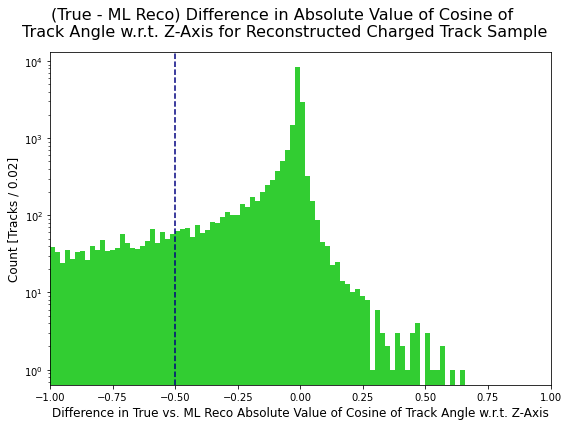

In [140]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_z']))-abs(np.cos(df_filtered['reco_angle_z']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Z-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_z_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

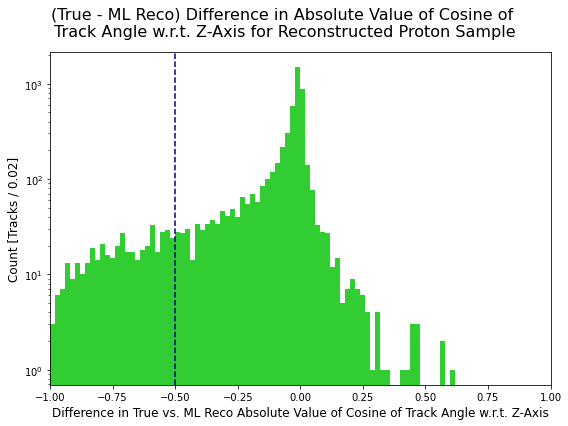

In [141]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_z']))-abs(np.cos(df_protons['reco_angle_z']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Z-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_z_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

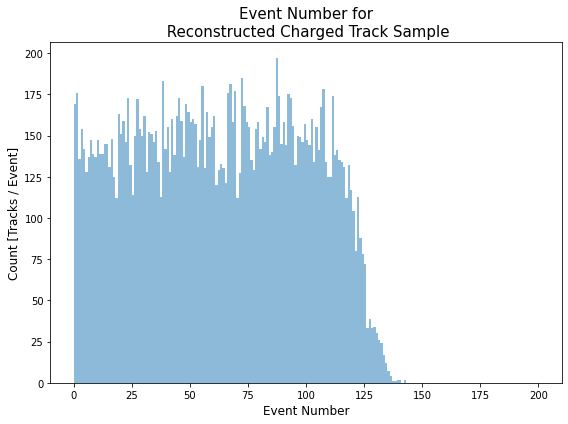

In [142]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['event'], alpha=0.5, bins=200, range=(0, 200), histtype='stepfilled')
axs.set_xlabel('Event Number', fontsize=12)
axs.set_ylabel('Count [Tracks / Event]', fontsize=12)
#axs.set_xlim(0, 100000)


axs.set_title('Event Number for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'event_number_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

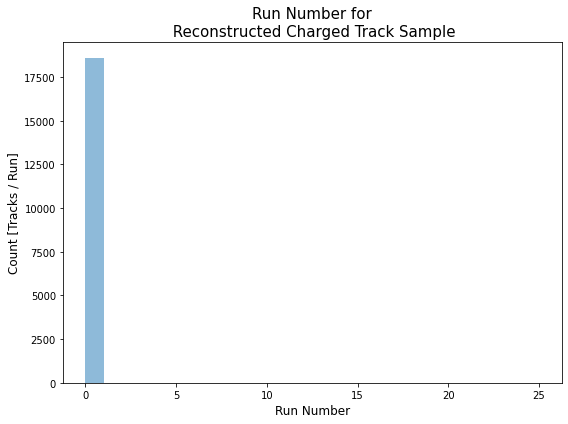

In [143]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['run'], alpha=0.5, bins=25, range=(0, 25), histtype='stepfilled')
axs.set_xlabel('Run Number', fontsize=12)
axs.set_ylabel('Count [Tracks / Run]', fontsize=12)
#axs.set_xlim(0, 100000)


axs.set_title('Run Number for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'run_number_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

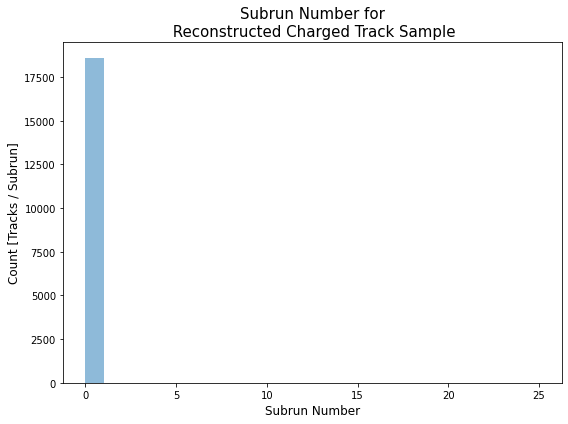

In [144]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['subrun'], alpha=0.5, bins=25, range=(0, 25), histtype='stepfilled')
axs.set_xlabel('Subrun Number', fontsize=12)
axs.set_ylabel('Count [Tracks / Subrun]', fontsize=12)
#axs.set_xlim(0, 100000)


axs.set_title('Subrun Number for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'subrun_number_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

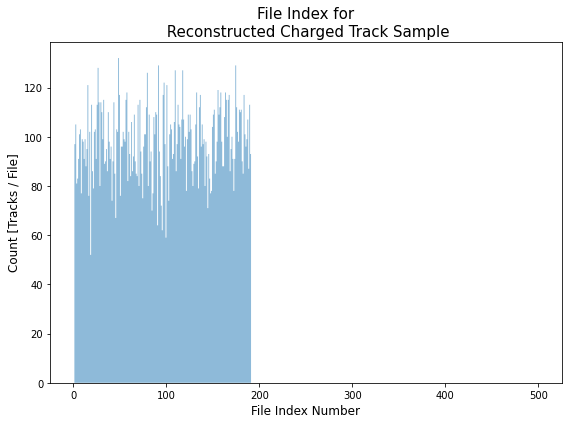

In [145]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['file_index'], alpha=0.5, bins=500, range=(0, 500), histtype='stepfilled')
axs.set_xlabel('File Index Number', fontsize=12)
axs.set_ylabel('Count [Tracks / File]', fontsize=12)
#axs.set_xlim(0, 100000)


axs.set_title('File Index for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'file_index_number_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

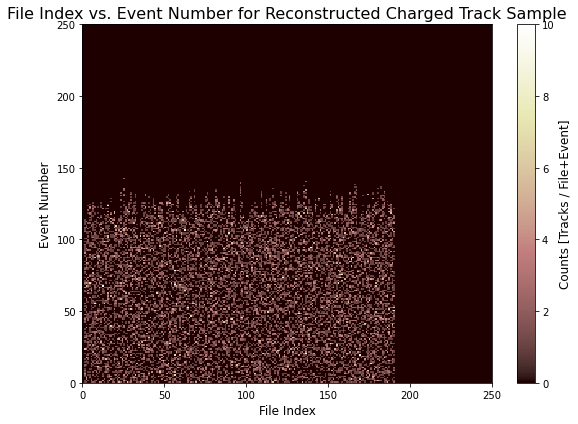

In [146]:
# Charged Track Lengths 2D Hist

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'

fig, ax = plt.subplots(figsize=[8,6])

counts, xedges, yedges, im = ax.hist2d(df_filtered['file_index'], df_filtered['event'], bins=250, range=[[0, 250], [0, 250]], cmap='pink')

ax.set_xlabel('File Index', fontsize=12)
ax.set_ylabel('Event Number', fontsize=12)
ax.set_title('File Index vs. Event Number for Reconstructed Charged Track Sample', fontsize=16)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts [Tracks / File+Event]', fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'file_index_vs_event_number_2d_hist_with_ovlp_cut_'+str(ovlp_cut)+'.png')
#plt.show()

In [147]:
df_filtered['caf_file_name']

entry  subentry
0      0           (/pnfs/dune/persistent/users/mkramer/productio...
       1           (/pnfs/dune/persistent/users/mkramer/productio...
       2           (/pnfs/dune/persistent/users/mkramer/productio...
       3           (/pnfs/dune/persistent/users/mkramer/productio...
       4           (/pnfs/dune/persistent/users/mkramer/productio...
                                         ...                        
       23351       (/pnfs/dune/persistent/users/mkramer/productio...
       23352       (/pnfs/dune/persistent/users/mkramer/productio...
       23353       (/pnfs/dune/persistent/users/mkramer/productio...
       23354       (/pnfs/dune/persistent/users/mkramer/productio...
       23355       (/pnfs/dune/persistent/users/mkramer/productio...
Name: caf_file_name, Length: 18587, dtype: object